## Importing libraries

In [14]:
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2
import time
from keras import losses
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Dense
from keras.layers.merge import concatenate
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.optimizers import Adadelta, SGD, Adam
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import concatenate
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from IPython.display import SVG
from tqdm import tqdm, tqdm_notebook
from keras.utils import plot_model

## Importing data from CSVs.

In [15]:
features_data = pd.read_csv("15features.csv")
training_data = pd.read_csv("seen-dataset/dataset_seen_training_siamese.csv")
validation_data = pd.read_csv("seen-dataset/dataset_seen_validation_siamese.csv")

training_data = training_data.drop('Unnamed: 0',1)
validation_data = validation_data.drop('Unnamed: 0',1)

train_path = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_path)
#print(len(train_images))
val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)

columns = features_data.columns

#Get the unique no of values a given feature can take.
features_values = []
for i in columns[1:]:
    #print(i)
    features_values.append(features_data[i].unique().shape[0])
features_values

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

## Datagen

In [16]:
def datagen(batch_size,image_path,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    
    
    while True:
        counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
#             class_vectors = []
            writer = list_of_writers[writer_index]
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]

    
            loaded_image = cv2.imread(os.path.join(image_path,writer),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
#             loaded_image = np.expand_dims(loaded_image,-1)
#             loaded_image_shifted = np.expand_dims(loaded_image_shifted,-1)
#             print('csv_writer:', csv_writer, ', writer:', writer)
#             display(csv_data[csv_data['ImageId'].str.match(csv_writer)])
#             csv_discrete_features = csv_data[csv_data['ImageId'].str.match(csv_writer)].iloc[0].values[2:]
#             print(csv_writer, writer_samples[writer_sample_index])
#             print(csv_writer,csv_discreete_features)
#             for i in range(1,9):
#                 print(csv_discreete_features[i-1],end=',')
#             f_1_out.append(csv_discreete_features[0])
#             f_2_out.append(csv_discreete_features[1])
#             f_3_out.append(csv_discreete_features[2])
#             f_4_out.append(csv_discreete_features[3])
#             f_5_out.append(csv_discreete_features[4])
#             f_6_out.append(csv_discreete_features[5])
#             f_7_out.append(csv_discreete_features[6])
#             f_8_out.append(csv_discreete_features[7])
#                 class_vectors.append(to_categorical(csv_discreete_features[i-1],num_classes=feature_lengths['f'+str(i)]))
#             print("\n",len(class_vectors))
#             print('\n-----------')
            
#             print("++++++++++++++++++++++[",counter,"]+++++++++++++++++++++++")
        #     imgcounter = 0
        #     for sample in writer_samples:
        #         imagepath = os.path.join(image_path,sample)
        #         raw_img = cv2.imread(imagepath)
        #         imgcounter+=1
        #     imgcounter=0
        #     identitycounter += 1
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer)
            ids.append(writer_index)
            
            counter+=1
#             print('counter:', counter, end='\r')
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0

## AutoEncoder

In [17]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
__________

##  Generators

In [18]:
train_path = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_path)
#len(train_images)
val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
#len(val_images)

train_list_of_writers = train_images
val_list_of_writers = val_images
batch_size = 64

training_datagen = datagen(batch_size,train_path,train_list_of_writers, hshift = (-10,10))
validation_datagen = datagen(batch_size,val_path,val_list_of_writers, hshift = (-10,10))

## SVG

In [19]:
#SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
plot_model(autoencoder, to_file='autoencoder.png')

## Model Checkpoint and Early Stopping

In [29]:
mc = ModelCheckpoint(filepath='model_mc_seen.h5', 
                     monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
#autoencoder.load_weights('simple_ae_maxpool_less_weights_v3.h5')

## Fitting the generator

In [30]:
EPOCHS = 5000

hist = autoencoder.fit_generator(training_datagen, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = validation_datagen
                                    , validation_steps = 1
                                    , verbose = 3                                    
                                   )
autoencoder.save_weights("saved-model_mc_seen.h5")
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)
plot_model(encoder, to_file='encoder.png')

Epoch 1/5000

Epoch 00001: val_loss improved from inf to 0.68732, saving model to model_mc_seen.h5
Epoch 2/5000

Epoch 00002: val_loss improved from 0.68732 to 0.67538, saving model to model_mc_seen.h5
Epoch 3/5000

Epoch 00003: val_loss improved from 0.67538 to 0.65494, saving model to model_mc_seen.h5
Epoch 4/5000

Epoch 00004: val_loss improved from 0.65494 to 0.61170, saving model to model_mc_seen.h5
Epoch 5/5000

Epoch 00005: val_loss improved from 0.61170 to 0.50255, saving model to model_mc_seen.h5
Epoch 6/5000

Epoch 00006: val_loss improved from 0.50255 to 0.31040, saving model to model_mc_seen.h5
Epoch 7/5000

Epoch 00007: val_loss did not improve from 0.31040
Epoch 8/5000

Epoch 00008: val_loss improved from 0.31040 to 0.30368, saving model to model_mc_seen.h5
Epoch 9/5000

Epoch 00009: val_loss did not improve from 0.30368
Epoch 10/5000

Epoch 00010: val_loss improved from 0.30368 to 0.30325, saving model to model_mc_seen.h5
Epoch 11/5000

Epoch 00011: val_loss did not impr

Epoch 00233: val_loss did not improve from 0.15737
Epoch 234/5000

Epoch 00234: val_loss did not improve from 0.15737
Epoch 235/5000

Epoch 00235: val_loss did not improve from 0.15737
Epoch 236/5000

Epoch 00236: val_loss improved from 0.15737 to 0.15718, saving model to model_mc_seen.h5
Epoch 237/5000

Epoch 00237: val_loss did not improve from 0.15718
Epoch 238/5000

Epoch 00238: val_loss did not improve from 0.15718
Epoch 239/5000

Epoch 00239: val_loss did not improve from 0.15718
Epoch 240/5000

Epoch 00240: val_loss did not improve from 0.15718
Epoch 241/5000

Epoch 00241: val_loss did not improve from 0.15718
Epoch 242/5000

Epoch 00242: val_loss did not improve from 0.15718
Epoch 243/5000

Epoch 00243: val_loss did not improve from 0.15718
Epoch 244/5000

Epoch 00244: val_loss did not improve from 0.15718
Epoch 245/5000

Epoch 00245: val_loss did not improve from 0.15718
Epoch 246/5000

Epoch 00246: val_loss did not improve from 0.15718
Epoch 247/5000

Epoch 00247: val_loss di

Epoch 00474: val_loss did not improve from 0.15234
Epoch 475/5000

Epoch 00475: val_loss did not improve from 0.15234
Epoch 476/5000

Epoch 00476: val_loss did not improve from 0.15234
Epoch 477/5000

Epoch 00477: val_loss did not improve from 0.15234
Epoch 478/5000

Epoch 00478: val_loss did not improve from 0.15234
Epoch 479/5000

Epoch 00479: val_loss did not improve from 0.15234
Epoch 480/5000

Epoch 00480: val_loss did not improve from 0.15234
Epoch 481/5000

Epoch 00481: val_loss improved from 0.15234 to 0.14898, saving model to model_mc_seen.h5
Epoch 482/5000

Epoch 00482: val_loss did not improve from 0.14898
Epoch 483/5000

Epoch 00483: val_loss did not improve from 0.14898
Epoch 484/5000

Epoch 00484: val_loss did not improve from 0.14898
Epoch 485/5000

Epoch 00485: val_loss did not improve from 0.14898
Epoch 486/5000

Epoch 00486: val_loss did not improve from 0.14898
Epoch 487/5000

Epoch 00487: val_loss did not improve from 0.14898
Epoch 488/5000

Epoch 00488: val_loss di

Epoch 00715: val_loss did not improve from 0.14436
Epoch 716/5000

Epoch 00716: val_loss did not improve from 0.14436
Epoch 717/5000

Epoch 00717: val_loss did not improve from 0.14436
Epoch 718/5000

Epoch 00718: val_loss did not improve from 0.14436
Epoch 719/5000

Epoch 00719: val_loss did not improve from 0.14436
Epoch 720/5000

Epoch 00720: val_loss did not improve from 0.14436
Epoch 721/5000

Epoch 00721: val_loss did not improve from 0.14436
Epoch 722/5000

Epoch 00722: val_loss did not improve from 0.14436
Epoch 723/5000

Epoch 00723: val_loss did not improve from 0.14436
Epoch 724/5000

Epoch 00724: val_loss did not improve from 0.14436
Epoch 725/5000

Epoch 00725: val_loss did not improve from 0.14436
Epoch 726/5000

Epoch 00726: val_loss did not improve from 0.14436
Epoch 727/5000

Epoch 00727: val_loss did not improve from 0.14436
Epoch 728/5000

Epoch 00728: val_loss did not improve from 0.14436
Epoch 729/5000

Epoch 00729: val_loss did not improve from 0.14436
Epoch 730/5

Epoch 00958: val_loss did not improve from 0.14195
Epoch 959/5000

Epoch 00959: val_loss did not improve from 0.14195
Epoch 960/5000

Epoch 00960: val_loss did not improve from 0.14195
Epoch 961/5000

Epoch 00961: val_loss did not improve from 0.14195
Epoch 962/5000

Epoch 00962: val_loss did not improve from 0.14195
Epoch 963/5000

Epoch 00963: val_loss did not improve from 0.14195
Epoch 964/5000

Epoch 00964: val_loss did not improve from 0.14195
Epoch 965/5000

Epoch 00965: val_loss did not improve from 0.14195
Epoch 966/5000

Epoch 00966: val_loss did not improve from 0.14195
Epoch 967/5000

Epoch 00967: val_loss did not improve from 0.14195
Epoch 968/5000

Epoch 00968: val_loss did not improve from 0.14195
Epoch 969/5000

Epoch 00969: val_loss did not improve from 0.14195
Epoch 970/5000

Epoch 00970: val_loss did not improve from 0.14195
Epoch 971/5000

Epoch 00971: val_loss did not improve from 0.14195
Epoch 972/5000

Epoch 00972: val_loss did not improve from 0.14195
Epoch 973/5

Epoch 1199/5000

Epoch 01199: val_loss did not improve from 0.14093
Epoch 1200/5000

Epoch 01200: val_loss did not improve from 0.14093
Epoch 1201/5000

Epoch 01201: val_loss improved from 0.14093 to 0.14056, saving model to model_mc_seen.h5
Epoch 1202/5000

Epoch 01202: val_loss did not improve from 0.14056
Epoch 1203/5000

Epoch 01203: val_loss did not improve from 0.14056
Epoch 1204/5000

Epoch 01204: val_loss did not improve from 0.14056
Epoch 1205/5000

Epoch 01205: val_loss did not improve from 0.14056
Epoch 1206/5000

Epoch 01206: val_loss did not improve from 0.14056
Epoch 1207/5000

Epoch 01207: val_loss did not improve from 0.14056
Epoch 1208/5000

Epoch 01208: val_loss did not improve from 0.14056
Epoch 1209/5000

Epoch 01209: val_loss did not improve from 0.14056
Epoch 1210/5000

Epoch 01210: val_loss did not improve from 0.14056
Epoch 1211/5000

Epoch 01211: val_loss improved from 0.14056 to 0.13959, saving model to model_mc_seen.h5
Epoch 1212/5000

Epoch 01212: val_loss d

Epoch 01317: val_loss did not improve from 0.13819
Epoch 1318/5000

Epoch 01318: val_loss did not improve from 0.13819
Epoch 1319/5000

Epoch 01319: val_loss did not improve from 0.13819
Epoch 1320/5000

Epoch 01320: val_loss did not improve from 0.13819
Epoch 1321/5000

Epoch 01321: val_loss did not improve from 0.13819
Epoch 1322/5000

Epoch 01322: val_loss did not improve from 0.13819
Epoch 1323/5000

Epoch 01323: val_loss did not improve from 0.13819
Epoch 1324/5000

Epoch 01324: val_loss did not improve from 0.13819
Epoch 1325/5000

Epoch 01325: val_loss improved from 0.13819 to 0.13751, saving model to model_mc_seen.h5
Epoch 1326/5000

Epoch 01326: val_loss did not improve from 0.13751
Epoch 1327/5000

Epoch 01327: val_loss did not improve from 0.13751
Epoch 1328/5000

Epoch 01328: val_loss did not improve from 0.13751
Epoch 1329/5000

Epoch 01329: val_loss did not improve from 0.13751
Epoch 1330/5000

Epoch 01330: val_loss did not improve from 0.13751
Epoch 1331/5000

Epoch 0133

Epoch 01556: val_loss did not improve from 0.13545
Epoch 1557/5000

Epoch 01557: val_loss did not improve from 0.13545
Epoch 1558/5000

Epoch 01558: val_loss did not improve from 0.13545
Epoch 1559/5000

Epoch 01559: val_loss did not improve from 0.13545
Epoch 1560/5000

Epoch 01560: val_loss did not improve from 0.13545
Epoch 1561/5000

Epoch 01561: val_loss did not improve from 0.13545
Epoch 1562/5000

Epoch 01562: val_loss did not improve from 0.13545
Epoch 1563/5000

Epoch 01563: val_loss did not improve from 0.13545
Epoch 1564/5000

Epoch 01564: val_loss did not improve from 0.13545
Epoch 1565/5000

Epoch 01565: val_loss did not improve from 0.13545
Epoch 1566/5000

Epoch 01566: val_loss did not improve from 0.13545
Epoch 1567/5000

Epoch 01567: val_loss did not improve from 0.13545
Epoch 1568/5000

Epoch 01568: val_loss did not improve from 0.13545
Epoch 1569/5000

Epoch 01569: val_loss did not improve from 0.13545
Epoch 1570/5000

Epoch 01570: val_loss did not improve from 0.135

Epoch 01796: val_loss did not improve from 0.13085
Epoch 1797/5000

Epoch 01797: val_loss did not improve from 0.13085
Epoch 1798/5000

Epoch 01798: val_loss did not improve from 0.13085
Epoch 1799/5000

Epoch 01799: val_loss did not improve from 0.13085
Epoch 1800/5000

Epoch 01800: val_loss did not improve from 0.13085
Epoch 1801/5000

Epoch 01801: val_loss did not improve from 0.13085
Epoch 1802/5000

Epoch 01802: val_loss did not improve from 0.13085
Epoch 1803/5000

Epoch 01803: val_loss did not improve from 0.13085
Epoch 1804/5000

Epoch 01804: val_loss did not improve from 0.13085
Epoch 1805/5000

Epoch 01805: val_loss did not improve from 0.13085
Epoch 1806/5000

Epoch 01806: val_loss did not improve from 0.13085
Epoch 1807/5000

Epoch 01807: val_loss did not improve from 0.13085
Epoch 1808/5000

Epoch 01808: val_loss did not improve from 0.13085
Epoch 1809/5000

Epoch 01809: val_loss did not improve from 0.13085
Epoch 1810/5000

Epoch 01810: val_loss did not improve from 0.130

Epoch 02036: val_loss did not improve from 0.13085
Epoch 2037/5000

Epoch 02037: val_loss did not improve from 0.13085
Epoch 2038/5000

Epoch 02038: val_loss did not improve from 0.13085
Epoch 2039/5000

Epoch 02039: val_loss did not improve from 0.13085
Epoch 2040/5000

Epoch 02040: val_loss did not improve from 0.13085
Epoch 2041/5000

Epoch 02041: val_loss did not improve from 0.13085
Epoch 2042/5000

Epoch 02042: val_loss did not improve from 0.13085
Epoch 2043/5000

Epoch 02043: val_loss did not improve from 0.13085
Epoch 2044/5000

Epoch 02044: val_loss did not improve from 0.13085
Epoch 2045/5000

Epoch 02045: val_loss did not improve from 0.13085
Epoch 2046/5000

Epoch 02046: val_loss did not improve from 0.13085
Epoch 2047/5000

Epoch 02047: val_loss did not improve from 0.13085
Epoch 2048/5000

Epoch 02048: val_loss did not improve from 0.13085
Epoch 2049/5000

Epoch 02049: val_loss did not improve from 0.13085
Epoch 2050/5000

Epoch 02050: val_loss did not improve from 0.130

Epoch 02274: val_loss did not improve from 0.12853
Epoch 2275/5000

Epoch 02275: val_loss did not improve from 0.12853
Epoch 2276/5000

Epoch 02276: val_loss did not improve from 0.12853
Epoch 2277/5000

Epoch 02277: val_loss did not improve from 0.12853
Epoch 2278/5000

Epoch 02278: val_loss did not improve from 0.12853
Epoch 2279/5000

Epoch 02279: val_loss did not improve from 0.12853
Epoch 2280/5000

Epoch 02280: val_loss did not improve from 0.12853
Epoch 2281/5000

Epoch 02281: val_loss did not improve from 0.12853
Epoch 2282/5000

Epoch 02282: val_loss did not improve from 0.12853
Epoch 2283/5000

Epoch 02283: val_loss did not improve from 0.12853
Epoch 2284/5000

Epoch 02284: val_loss did not improve from 0.12853
Epoch 2285/5000

Epoch 02285: val_loss did not improve from 0.12853
Epoch 2286/5000

Epoch 02286: val_loss did not improve from 0.12853
Epoch 2287/5000

Epoch 02287: val_loss did not improve from 0.12853
Epoch 2288/5000

Epoch 02288: val_loss did not improve from 0.128

Epoch 02513: val_loss did not improve from 0.12585
Epoch 2514/5000

Epoch 02514: val_loss did not improve from 0.12585
Epoch 2515/5000

Epoch 02515: val_loss did not improve from 0.12585
Epoch 2516/5000

Epoch 02516: val_loss did not improve from 0.12585
Epoch 2517/5000

Epoch 02517: val_loss did not improve from 0.12585
Epoch 2518/5000

Epoch 02518: val_loss did not improve from 0.12585
Epoch 2519/5000

Epoch 02519: val_loss did not improve from 0.12585
Epoch 2520/5000

Epoch 02520: val_loss did not improve from 0.12585
Epoch 2521/5000

Epoch 02521: val_loss did not improve from 0.12585
Epoch 2522/5000

Epoch 02522: val_loss did not improve from 0.12585
Epoch 2523/5000

Epoch 02523: val_loss did not improve from 0.12585
Epoch 2524/5000

Epoch 02524: val_loss did not improve from 0.12585
Epoch 2525/5000

Epoch 02525: val_loss did not improve from 0.12585
Epoch 2526/5000

Epoch 02526: val_loss did not improve from 0.12585
Epoch 2527/5000

Epoch 02527: val_loss did not improve from 0.125

Epoch 2752/5000

Epoch 02752: val_loss did not improve from 0.12401
Epoch 2753/5000

Epoch 02753: val_loss did not improve from 0.12401
Epoch 2754/5000

Epoch 02754: val_loss did not improve from 0.12401
Epoch 2755/5000

Epoch 02755: val_loss did not improve from 0.12401
Epoch 2756/5000

Epoch 02756: val_loss did not improve from 0.12401
Epoch 2757/5000

Epoch 02757: val_loss did not improve from 0.12401
Epoch 2758/5000

Epoch 02758: val_loss did not improve from 0.12401
Epoch 2759/5000

Epoch 02759: val_loss did not improve from 0.12401
Epoch 2760/5000

Epoch 02760: val_loss did not improve from 0.12401
Epoch 2761/5000

Epoch 02761: val_loss did not improve from 0.12401
Epoch 2762/5000

Epoch 02762: val_loss did not improve from 0.12401
Epoch 2763/5000

Epoch 02763: val_loss did not improve from 0.12401
Epoch 2764/5000

Epoch 02764: val_loss did not improve from 0.12401
Epoch 2765/5000

Epoch 02765: val_loss did not improve from 0.12401
Epoch 2766/5000

Epoch 02766: val_loss did not i

Epoch 2992/5000

Epoch 02992: val_loss did not improve from 0.12082
Epoch 2993/5000

Epoch 02993: val_loss did not improve from 0.12082
Epoch 2994/5000

Epoch 02994: val_loss did not improve from 0.12082
Epoch 2995/5000

Epoch 02995: val_loss did not improve from 0.12082
Epoch 2996/5000

Epoch 02996: val_loss did not improve from 0.12082
Epoch 2997/5000

Epoch 02997: val_loss did not improve from 0.12082
Epoch 2998/5000

Epoch 02998: val_loss did not improve from 0.12082
Epoch 2999/5000

Epoch 02999: val_loss did not improve from 0.12082
Epoch 3000/5000

Epoch 03000: val_loss did not improve from 0.12082
Epoch 3001/5000

Epoch 03001: val_loss did not improve from 0.12082
Epoch 3002/5000

Epoch 03002: val_loss did not improve from 0.12082
Epoch 3003/5000

Epoch 03003: val_loss did not improve from 0.12082
Epoch 3004/5000

Epoch 03004: val_loss did not improve from 0.12082
Epoch 3005/5000

Epoch 03005: val_loss did not improve from 0.12082
Epoch 3006/5000

Epoch 03006: val_loss did not i

Epoch 3232/5000

Epoch 03232: val_loss did not improve from 0.11806
Epoch 3233/5000

Epoch 03233: val_loss did not improve from 0.11806
Epoch 3234/5000

Epoch 03234: val_loss did not improve from 0.11806
Epoch 3235/5000

Epoch 03235: val_loss did not improve from 0.11806
Epoch 3236/5000

Epoch 03236: val_loss did not improve from 0.11806
Epoch 3237/5000

Epoch 03237: val_loss did not improve from 0.11806
Epoch 3238/5000

Epoch 03238: val_loss did not improve from 0.11806
Epoch 3239/5000

Epoch 03239: val_loss did not improve from 0.11806
Epoch 3240/5000

Epoch 03240: val_loss did not improve from 0.11806
Epoch 3241/5000

Epoch 03241: val_loss did not improve from 0.11806
Epoch 3242/5000

Epoch 03242: val_loss did not improve from 0.11806
Epoch 3243/5000

Epoch 03243: val_loss did not improve from 0.11806
Epoch 3244/5000

Epoch 03244: val_loss did not improve from 0.11806
Epoch 3245/5000

Epoch 03245: val_loss did not improve from 0.11806
Epoch 3246/5000

Epoch 03246: val_loss did not i

Epoch 03472: val_loss did not improve from 0.11806
Epoch 3473/5000

Epoch 03473: val_loss did not improve from 0.11806
Epoch 3474/5000

Epoch 03474: val_loss did not improve from 0.11806
Epoch 3475/5000

Epoch 03475: val_loss did not improve from 0.11806
Epoch 3476/5000

Epoch 03476: val_loss did not improve from 0.11806
Epoch 3477/5000

Epoch 03477: val_loss did not improve from 0.11806
Epoch 3478/5000

Epoch 03478: val_loss did not improve from 0.11806
Epoch 3479/5000

Epoch 03479: val_loss did not improve from 0.11806
Epoch 3480/5000

Epoch 03480: val_loss did not improve from 0.11806
Epoch 3481/5000

Epoch 03481: val_loss did not improve from 0.11806
Epoch 3482/5000

Epoch 03482: val_loss did not improve from 0.11806
Epoch 3483/5000

Epoch 03483: val_loss did not improve from 0.11806
Epoch 3484/5000

Epoch 03484: val_loss did not improve from 0.11806
Epoch 3485/5000

Epoch 03485: val_loss did not improve from 0.11806
Epoch 3486/5000

Epoch 03486: val_loss did not improve from 0.118

Epoch 03712: val_loss did not improve from 0.11691
Epoch 3713/5000

Epoch 03713: val_loss did not improve from 0.11691
Epoch 3714/5000

Epoch 03714: val_loss did not improve from 0.11691
Epoch 3715/5000

Epoch 03715: val_loss did not improve from 0.11691
Epoch 3716/5000

Epoch 03716: val_loss did not improve from 0.11691
Epoch 3717/5000

Epoch 03717: val_loss did not improve from 0.11691
Epoch 3718/5000

Epoch 03718: val_loss did not improve from 0.11691
Epoch 3719/5000

Epoch 03719: val_loss did not improve from 0.11691
Epoch 3720/5000

Epoch 03720: val_loss did not improve from 0.11691
Epoch 3721/5000

Epoch 03721: val_loss did not improve from 0.11691
Epoch 3722/5000

Epoch 03722: val_loss did not improve from 0.11691
Epoch 3723/5000

Epoch 03723: val_loss did not improve from 0.11691
Epoch 3724/5000

Epoch 03724: val_loss did not improve from 0.11691
Epoch 3725/5000

Epoch 03725: val_loss did not improve from 0.11691
Epoch 3726/5000

Epoch 03726: val_loss did not improve from 0.116

Epoch 03951: val_loss did not improve from 0.11590
Epoch 3952/5000

Epoch 03952: val_loss did not improve from 0.11590
Epoch 3953/5000

Epoch 03953: val_loss did not improve from 0.11590
Epoch 3954/5000

Epoch 03954: val_loss did not improve from 0.11590
Epoch 3955/5000

Epoch 03955: val_loss did not improve from 0.11590
Epoch 3956/5000

Epoch 03956: val_loss did not improve from 0.11590
Epoch 3957/5000

Epoch 03957: val_loss did not improve from 0.11590
Epoch 3958/5000

Epoch 03958: val_loss did not improve from 0.11590
Epoch 3959/5000

Epoch 03959: val_loss did not improve from 0.11590
Epoch 3960/5000

Epoch 03960: val_loss did not improve from 0.11590
Epoch 3961/5000

Epoch 03961: val_loss did not improve from 0.11590
Epoch 3962/5000

Epoch 03962: val_loss did not improve from 0.11590
Epoch 3963/5000

Epoch 03963: val_loss did not improve from 0.11590
Epoch 3964/5000

Epoch 03964: val_loss did not improve from 0.11590
Epoch 3965/5000

Epoch 03965: val_loss did not improve from 0.115

Epoch 04191: val_loss did not improve from 0.11590
Epoch 4192/5000

Epoch 04192: val_loss did not improve from 0.11590
Epoch 4193/5000

Epoch 04193: val_loss did not improve from 0.11590
Epoch 4194/5000

Epoch 04194: val_loss did not improve from 0.11590
Epoch 4195/5000

Epoch 04195: val_loss did not improve from 0.11590
Epoch 4196/5000

Epoch 04196: val_loss did not improve from 0.11590
Epoch 4197/5000

Epoch 04197: val_loss did not improve from 0.11590
Epoch 4198/5000

Epoch 04198: val_loss did not improve from 0.11590
Epoch 4199/5000

Epoch 04199: val_loss did not improve from 0.11590
Epoch 4200/5000

Epoch 04200: val_loss did not improve from 0.11590
Epoch 4201/5000

Epoch 04201: val_loss did not improve from 0.11590
Epoch 4202/5000

Epoch 04202: val_loss did not improve from 0.11590
Epoch 4203/5000

Epoch 04203: val_loss did not improve from 0.11590
Epoch 4204/5000

Epoch 04204: val_loss did not improve from 0.11590
Epoch 4205/5000

Epoch 04205: val_loss did not improve from 0.115

Epoch 4431/5000

Epoch 04431: val_loss did not improve from 0.11311
Epoch 4432/5000

Epoch 04432: val_loss did not improve from 0.11311
Epoch 4433/5000

Epoch 04433: val_loss did not improve from 0.11311
Epoch 4434/5000

Epoch 04434: val_loss did not improve from 0.11311
Epoch 4435/5000

Epoch 04435: val_loss did not improve from 0.11311
Epoch 4436/5000

Epoch 04436: val_loss did not improve from 0.11311
Epoch 4437/5000

Epoch 04437: val_loss did not improve from 0.11311
Epoch 4438/5000

Epoch 04438: val_loss did not improve from 0.11311
Epoch 4439/5000

Epoch 04439: val_loss did not improve from 0.11311
Epoch 4440/5000

Epoch 04440: val_loss did not improve from 0.11311
Epoch 4441/5000

Epoch 04441: val_loss did not improve from 0.11311
Epoch 4442/5000

Epoch 04442: val_loss did not improve from 0.11311
Epoch 4443/5000

Epoch 04443: val_loss did not improve from 0.11311
Epoch 4444/5000

Epoch 04444: val_loss did not improve from 0.11311
Epoch 4445/5000

Epoch 04445: val_loss did not i

Epoch 04671: val_loss did not improve from 0.11311
Epoch 4672/5000

Epoch 04672: val_loss did not improve from 0.11311
Epoch 4673/5000

Epoch 04673: val_loss did not improve from 0.11311
Epoch 4674/5000

Epoch 04674: val_loss did not improve from 0.11311
Epoch 4675/5000

Epoch 04675: val_loss did not improve from 0.11311
Epoch 4676/5000

Epoch 04676: val_loss did not improve from 0.11311
Epoch 4677/5000

Epoch 04677: val_loss did not improve from 0.11311
Epoch 4678/5000

Epoch 04678: val_loss did not improve from 0.11311
Epoch 4679/5000

Epoch 04679: val_loss did not improve from 0.11311
Epoch 4680/5000

Epoch 04680: val_loss did not improve from 0.11311
Epoch 4681/5000

Epoch 04681: val_loss did not improve from 0.11311
Epoch 4682/5000

Epoch 04682: val_loss did not improve from 0.11311
Epoch 4683/5000

Epoch 04683: val_loss did not improve from 0.11311
Epoch 4684/5000

Epoch 04684: val_loss did not improve from 0.11311
Epoch 4685/5000

Epoch 04685: val_loss did not improve from 0.113

Epoch 4911/5000

Epoch 04911: val_loss did not improve from 0.10923
Epoch 4912/5000

Epoch 04912: val_loss did not improve from 0.10923
Epoch 4913/5000

Epoch 04913: val_loss did not improve from 0.10923
Epoch 4914/5000

Epoch 04914: val_loss did not improve from 0.10923
Epoch 4915/5000

Epoch 04915: val_loss did not improve from 0.10923
Epoch 4916/5000

Epoch 04916: val_loss did not improve from 0.10923
Epoch 4917/5000

Epoch 04917: val_loss did not improve from 0.10923
Epoch 4918/5000

Epoch 04918: val_loss did not improve from 0.10923
Epoch 4919/5000

Epoch 04919: val_loss did not improve from 0.10923
Epoch 4920/5000

Epoch 04920: val_loss did not improve from 0.10923
Epoch 4921/5000

Epoch 04921: val_loss did not improve from 0.10923
Epoch 4922/5000

Epoch 04922: val_loss did not improve from 0.10923
Epoch 4923/5000

Epoch 04923: val_loss did not improve from 0.10923
Epoch 4924/5000

Epoch 04924: val_loss did not improve from 0.10923
Epoch 4925/5000

Epoch 04925: val_loss did not i

## Plots

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4BFCFCF60>,
      dtype=object)

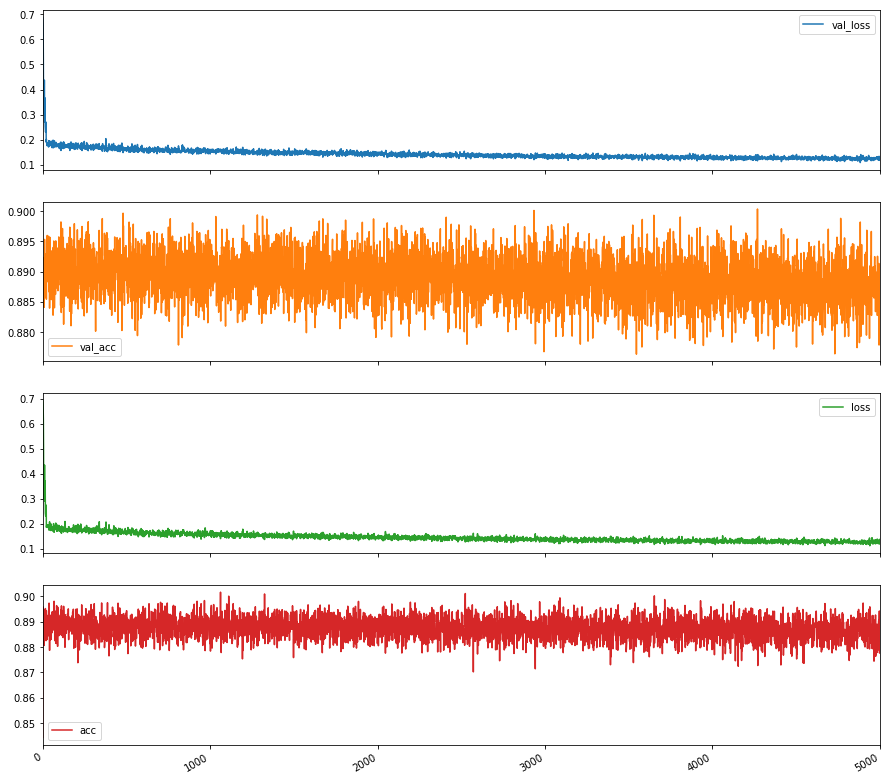

In [31]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,15))
#print(df_hist['val_loss'].min())
#df_hist[df_hist['val_loss']<=0.1054]

##  Prediction

(4760, 64, 64, 1) (4760,)


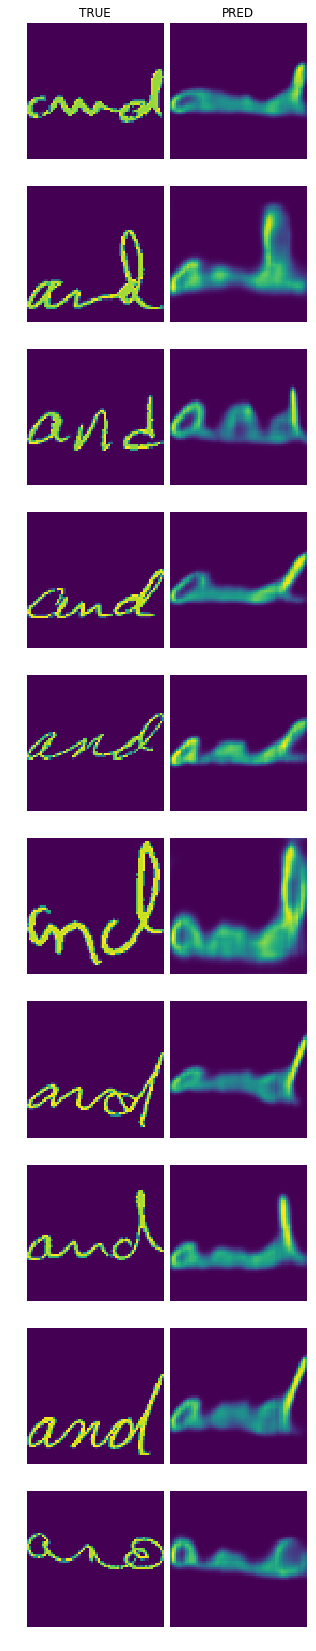

In [32]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)
test_g = datagen(len(val_list_of_writers)*5,val_path,val_list_of_writers, hshift = (-12,12), vis=True)
vx,vy = next(test_g)
print(vx.shape,vy[0].shape)
ids = vy[0].reshape(-1,1)
imagenames = vy[1].reshape(-1,1)
preds = encoder.predict(vx).reshape((-1,512))
# print(ids.shape,preds.shape)
# 
data=[]
for i in range(len(vx)):
    data.append([ids[i][0],imagenames[i][0],preds[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])

py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')


## Cosine Similarity

In [1]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.6
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 10
prev_query = ''
prev_given = ''
given_count = 0

if not os.path.isfile('results_cosine_dist_seen.csv'):
    for row in tqdm(cos_dist_out):

        c_counter = 0
        given_idx = df_data.iloc[r_counter]['identity']
        given_img = df_data.iloc[r_counter]['imagename']
        for col in row:
            queried_idx = df_data.iloc[c_counter]['identity']
            queried_img = df_data.iloc[c_counter]['imagename']
            if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
                tp += 1
            if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
                tn += 1
            if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
                fp += 1
                fp_list.append(os.path.join(queried_idx,queried_img))
            if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
                fn += 1
                fn_list.append(os.path.join(queried_idx,queried_img))
            if int(given_idx) == int(queried_idx):
                idx_count += 1
    #             print('--i--',idx_count,'--i--')
    #             print(given_idx,queried_idx)
            if prev_query != queried_idx:
    #             print('--q--',queried_count,'--q--')
                queried_count += 1
            c_counter += 1
            prev_query = queried_idx
    #         if queried_count == stop_at:
    #             break
        precision = tp/(fp+tp)
        recall = tp/(tp+fn)
        f1 = 2*(precision*recall)/(precision+recall)
        total = np.sum((tp,tn,fp,fn))
        accuracy = (tp+tn)/total
        data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
        if prev_given != given_idx:
    #         print('----',given_count,'-----')
            given_count+=1
        r_counter += 1
        prev_given = given_idx
        queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
        fp_list = []
        fn_list = []

    df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
    df_cos_dist_out=df_cos_dist_out.sort_values(by='identity').reset_index().drop(columns=['index'])
    df_cos_dist_out.to_csv('results_cosine_dist_seen.csv')
    total = df_cos_dist_out.shape[0]
    total_images_identity = df_cos_dist_out['total_images_identity']
    tps = df_cos_dist_out['TP'].sum()
    fps = df_cos_dist_out['FP'].sum()
    tns = df_cos_dist_out['TN'].sum()
    fns = df_cos_dist_out['FN'].sum()
    precision = tps/(fps+tps)
    recall = tps/(tps+fns)
    f1 = 2*(precision*recall)/(precision+recall)
    print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
    acc = df_cos_dist_out['accuracy'].mean()
    print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
    print('Inter Writer Accuracy (Type 2)::',tns/total/total)
    print('acc:',acc)
else:
    df_cos_dist_out = pd.read_csv('results_cosine_dist_seen.csv')
    total = df_cos_dist_out.shape[0]
    total_images_identity = df_cos_dist_out['total_images_identity']
    tps = df_cos_dist_out['TP'].sum()
    fps = df_cos_dist_out['FP'].sum()
    tns = df_cos_dist_out['TN'].sum()
    fns = df_cos_dist_out['FN'].sum()
    precision = tps/(fps+tps)
    recall = tps/(tps+fns)
    f1 = 2*(precision*recall)/(precision+recall)
    print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
    acc = df_cos_dist_out['accuracy'].mean()
    print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
    print('Inter Writer Accuracy (Type 2)::',tns/total/total)
    print('acc:',acc)

threshold: 0.66
precision: 0.02502739534740614 
recall: 0.8336552485316725 
f1: 0.04859588029912581
Intra Writer Accuracy (Type 1): 0.8354467762264937
Inter Writer Accuracy (Type 2):: 0.9250358378645577
acc: 0.9269026728338393

In [ ]:
# precision: 0.02502739534740614 
# recall: 0.8336552485316725 
# f1: 0.04859588029912581
# Intra Writer Accuracy (Type 1): 0.8354467762264937
# Inter Writer Accuracy (Type 2):: 0.9250358378645577
# acc: 0.9269026728338393